Signal Decomposition and motor unit detection

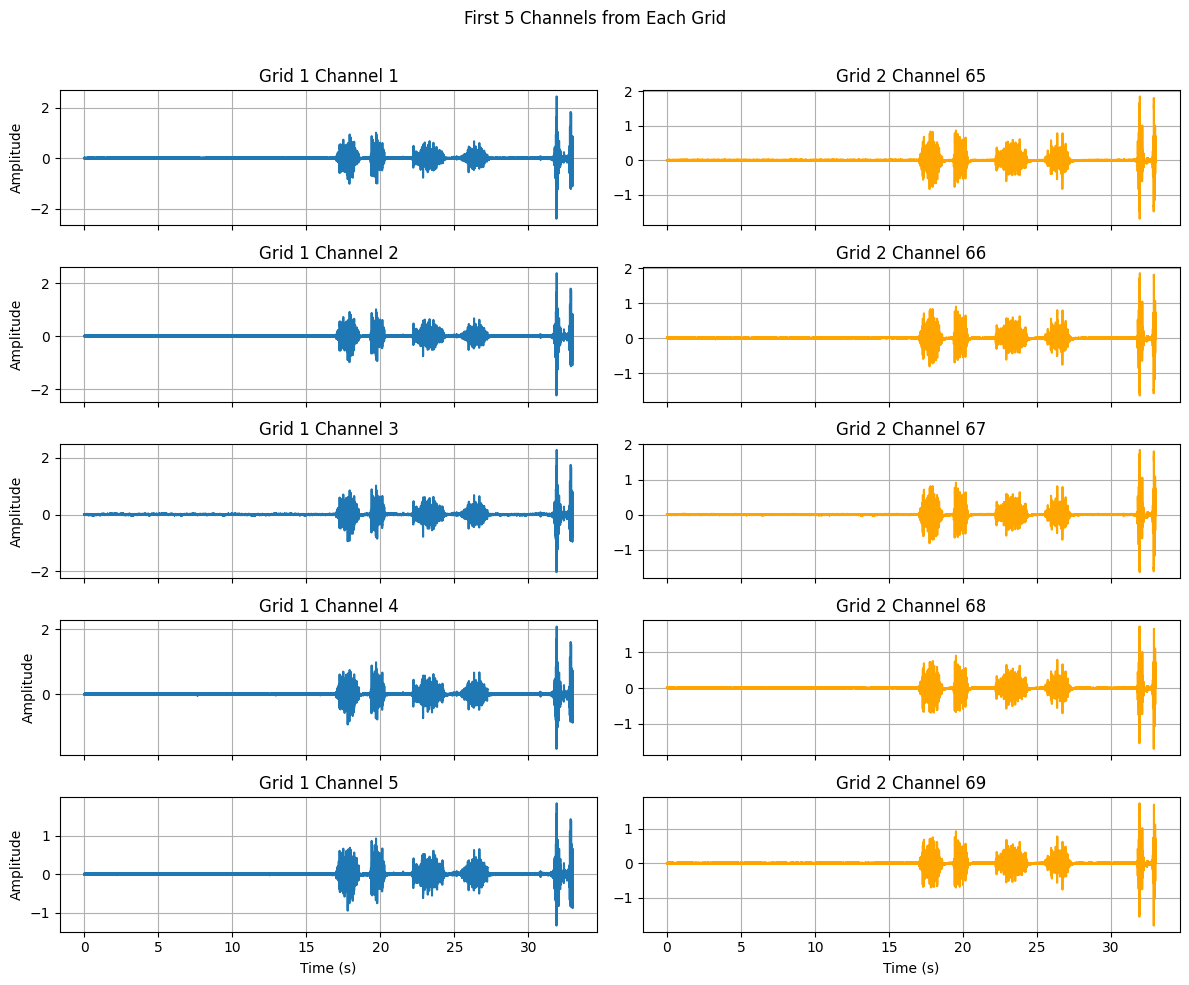

In [10]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# Load the CSV data using the correct file paths
file_path1 = "C:/Users/schmi/Documents/Studium/TUM/5. Semester/Masterthesis/Experimental Setup/OTB+/EMGLudgerGrit1.csv"
file_path2 = "C:/Users/schmi/Documents/Studium/TUM/5. Semester/Masterthesis/Experimental Setup/OTB+/EMGLudgerGrit2.csv"
emg_data_1 = pd.read_csv(file_path1, skiprows=3, sep=';', header=None)
emg_data_2 = pd.read_csv(file_path2, skiprows=3, sep=';', header=None)

# Convert data from comma to point if necessary and ensure it is numeric
emg_data_1 = emg_data_1.apply(lambda col: col.map(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x))
emg_data_2 = emg_data_2.apply(lambda col: col.map(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x))

# Extract time and signals
time_1 = emg_data_1.iloc[:, 0].values  # Time values from the first column of the first grid
signals_1 = emg_data_1.iloc[:, 1:].values  # EMG signals from 64 channels of the first grid

time_2 = emg_data_2.iloc[:, 0].values  # Time values from the first column of the second grid
signals_2 = emg_data_2.iloc[:, 1:].values  # EMG signals from 64 channels of the second grid

# Check if the time vectors are the same length and align them if necessary
min_length = min(len(time_1), len(time_2))
time_1 = time_1[:min_length]
time_2 = time_2[:min_length]
signals_1 = signals_1[:min_length]
signals_2 = signals_2[:min_length]

# Recalculate the time vector based on expected duration and step
time = np.arange(0, min_length * 0.0005, 0.0005)  # 0.0005 is the time step

# Plot the first 5 channels from each grid in separate boxes
num_channels_to_plot = 5
fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(12, 10), sharex=True)

for i in range(num_channels_to_plot):
    axs[i, 0].plot(time, signals_1[:, i])
    axs[i, 0].set_title(f'Grid 1 Channel {i+1}')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].grid(True)

    # Adjust index to start from channel 65 for grid 2
    axs[i, 1].plot(time, signals_2[:, i], color='orange')
    axs[i, 1].set_title(f'Grid 2 Channel {i+65}')
    axs[i, 1].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')

plt.suptitle('First 5 Channels from Each Grid')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Signal Processing. Normalizing, filtering rectification, Smoothening

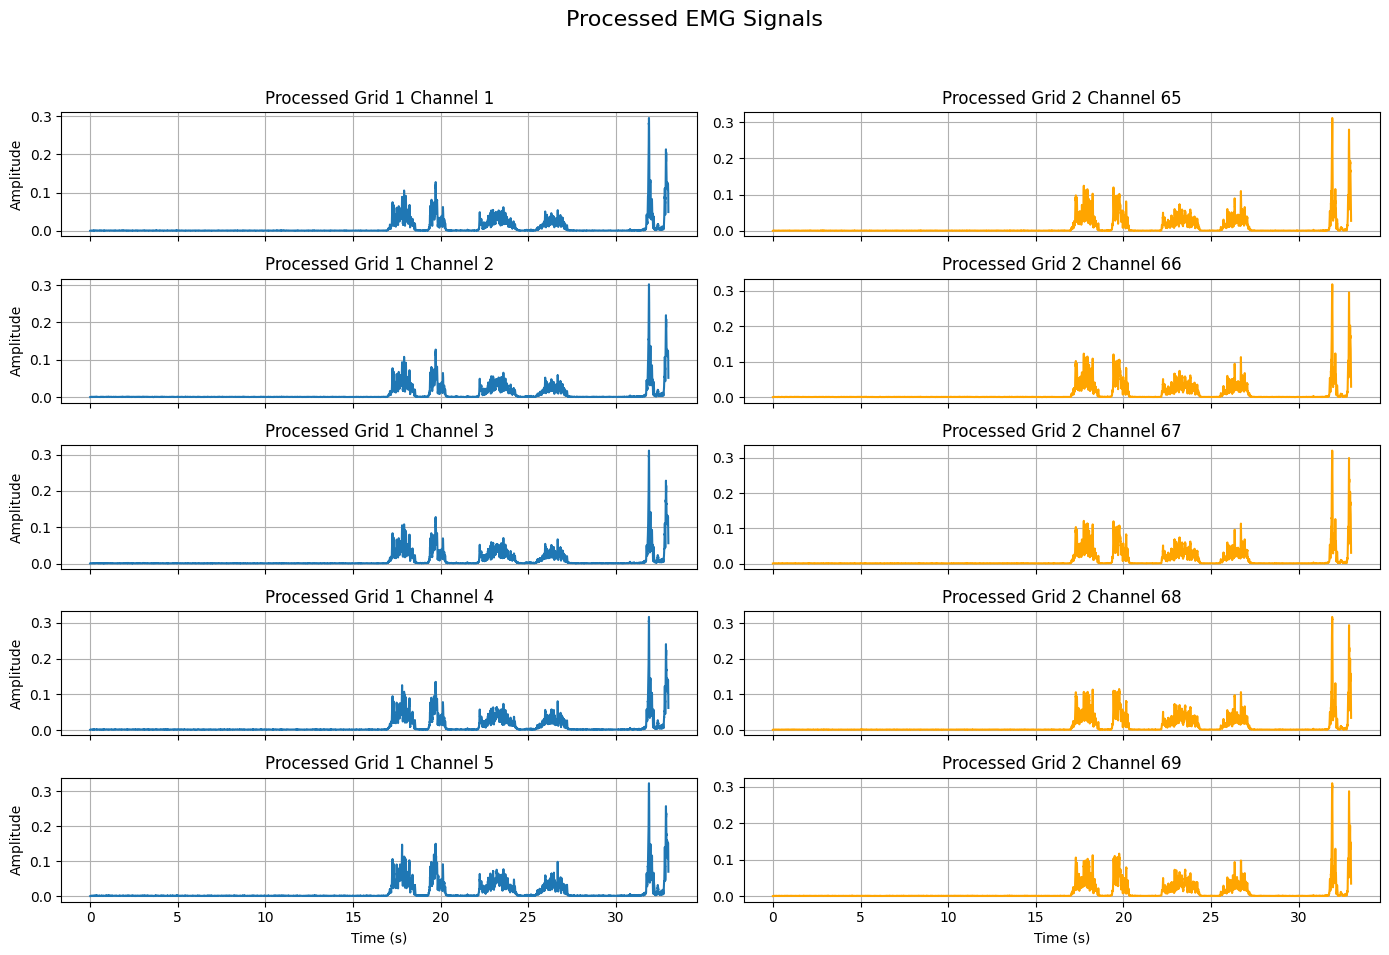

In [12]:
# Normalize the signals
def normalize_signals(signals):
    signals_min = np.min(signals, axis=0)
    signals_max = np.max(signals, axis=0)
    return (signals - signals_min) / (signals_max - signals_min)

signals_1 = normalize_signals(signals_1)
signals_2 = normalize_signals(signals_2)

# Define a function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# Preprocess the EMG data
fs = 1 / 0.0005  # Calculate sampling frequency based on the time step (0.0005 seconds)
lowcut = 20.0  # Lower bound frequency (Hz)
highcut = 450.0  # Upper bound frequency (Hz)

# Apply bandpass filter
filtered_signals_1 = bandpass_filter(signals_1, lowcut, highcut, fs)
filtered_signals_2 = bandpass_filter(signals_2, lowcut, highcut, fs)

# Rectify the signals (take the absolute value)
rectified_signals_1 = np.abs(filtered_signals_1)
rectified_signals_2 = np.abs(filtered_signals_2)

# Smooth the signals using a moving average
def smooth_signals(rectified_signals, window_size=50):
    smoothed_signals = np.zeros_like(rectified_signals)
    for i in range(rectified_signals.shape[1]):
        smoothed_signals[:, i] = np.convolve(rectified_signals[:, i], np.ones(window_size)/window_size, mode='same')
    return smoothed_signals

smoothed_signals_1 = smooth_signals(rectified_signals_1)
smoothed_signals_2 = smooth_signals(rectified_signals_2)

# Concatenate the smoothed signals from both grids
combined_smoothed_signals = np.hstack((smoothed_signals_1, smoothed_signals_2))

# Define the number of channels to plot
num_channels_to_plot = 5

# Create subplots
fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(14, 10), sharex=True)
fig.suptitle('Processed EMG Signals', fontsize=16)

for i in range(num_channels_to_plot):
    # Plot for Grid 1 (default color)
    axs[i, 0].plot(time, smoothed_signals_1[:, i])
    axs[i, 0].set_title(f'Processed Grid 1 Channel {i+1}')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].grid(True)

    # Plot for Grid 2 (orange color)
    axs[i, 1].plot(time, smoothed_signals_2[:, i], color='orange')
    axs[i, 1].set_title(f'Processed Grid 2 Channel {i+65}')
    axs[i, 1].grid(True)

# Set the x-label only on the bottom row
for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Motor Unit Decompostion

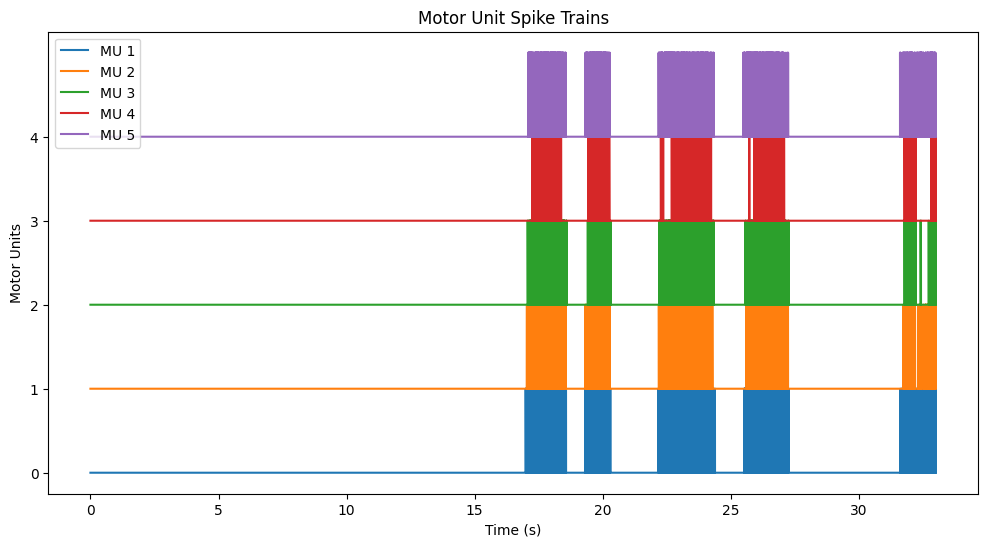

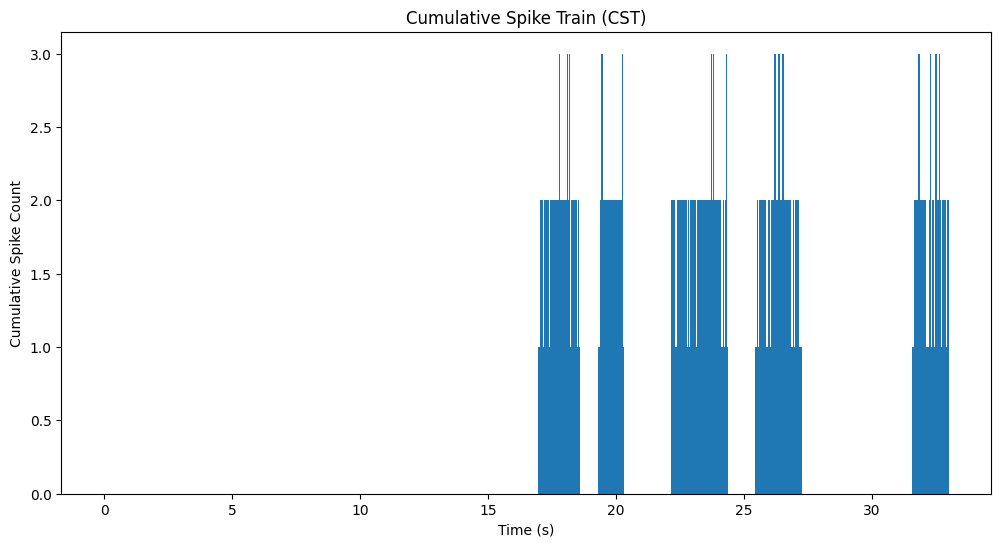

In [3]:

# Extract motor units using a decomposition method
def extract_motor_units(data, n_units=5):
    # Decompose the signal using NMF
    nmf = NMF(n_components=n_units, init='random', random_state=0, max_iter=1000)
    W = nmf.fit_transform(data)
    H = nmf.components_

    # Identify spikes for each motor unit based on activation threshold
    spike_trains = []
    for i in range(n_units):
        peaks, _ = find_peaks(W[:, i], height=0.05)  # Adjust threshold as needed
        spike_train = np.zeros(W.shape[0])
        spike_train[peaks] = 1
        spike_trains.append(spike_train)

    return W, H, spike_trains

W, H, spike_trains = extract_motor_units(combined_smoothed_signals, n_units=5)

# Plot each motor unit spike train
plt.figure(figsize=(12, 6))
for i, spike_train in enumerate(spike_trains):
    plt.plot(time, spike_train + i, label=f'MU {i+1}')
plt.title('Motor Unit Spike Trains')
plt.xlabel('Time (s)')
plt.ylabel('Motor Units')
plt.yticks(np.arange(len(spike_trains)))
plt.legend()
plt.show()

# Plot the cumulative spike train
cumulative_spike_train = np.sum(spike_trains, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(time, cumulative_spike_train, width=0.05)
plt.title('Cumulative Spike Train (CST)')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Spike Count')
plt.show()

Synergy Extraction 

c:\Users\schmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


W (Synergy Activation Coefficients):
[[0.00606039 0.00629711 0.00277551 0.00395681]
 [0.00632578 0.00645913 0.00285507 0.00408652]
 [0.00654023 0.00660237 0.00291376 0.00422508]
 ...
 [0.80065219 0.23045654 0.15291874 0.03752153]
 [0.75762464 0.21034573 0.15168591 0.0344886 ]
 [0.72055736 0.18914152 0.14608235 0.03211326]]

H (Synergy Weightings):
[[6.28524180e-02 6.35615765e-02 6.40366818e-02 6.28772417e-02
  6.11276922e-02 5.81597025e-02 5.45052611e-02 5.03976933e-02
  4.87636333e-02 4.17762373e-02 3.55665984e-02 3.23809600e-02
  6.32431633e-02 6.38816518e-02 6.47326871e-02 6.40510514e-02
  6.23567649e-02 6.08110144e-02 5.63822360e-02 5.35366868e-02
  4.71605514e-02 4.07339134e-02 3.75248993e-02 3.45486815e-02
  2.99865816e-02 6.54169613e-02 6.62373517e-02 6.51229082e-02
  6.27230934e-02 5.94189711e-02 5.39352328e-02 5.03685633e-02
  4.00645317e-02 3.50115687e-02 3.01219271e-02 2.49690341e-02
  2.39350478e-02 2.93737649e-02 6.79093477e-02 6.77868450e-02
  6.52848411e-02 6.12844871e-0

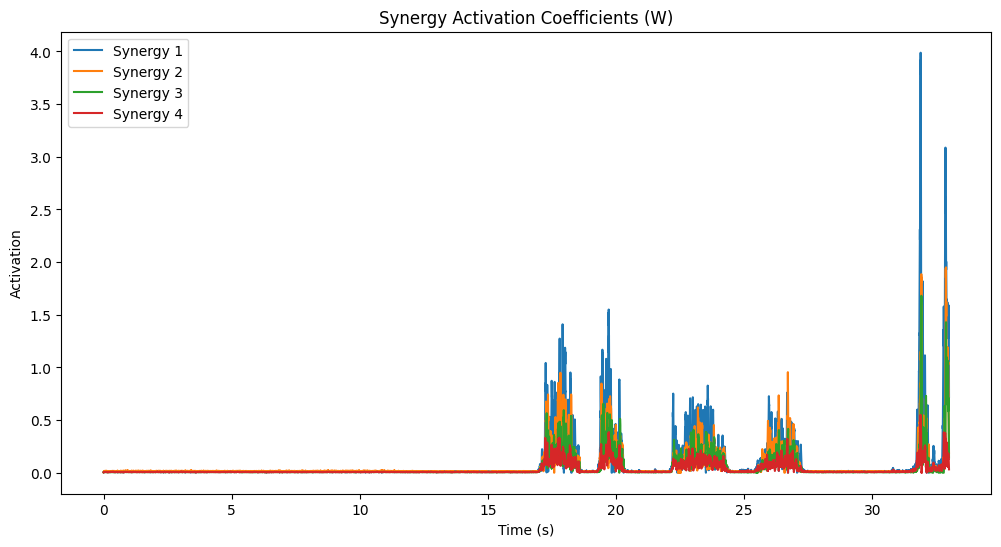

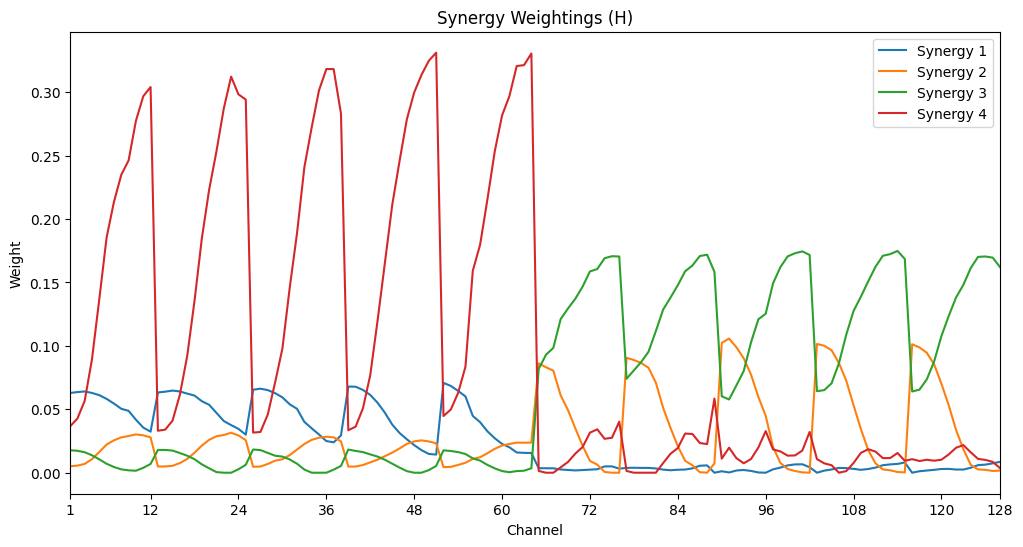

In [19]:
# Extract muscle synergies using NMF
n_synergies = 4  # Number of synergies to extract
model = NMF(n_components=n_synergies, init='random', random_state=0, max_iter=500)
W = model.fit_transform(combined_smoothed_signals)
H = model.components_

# Results
print("W (Synergy Activation Coefficients):")
print(W)
print("\nH (Synergy Weightings):")
print(H)

# Plot the synergy activation coefficients (W)
plt.figure(figsize=(12, 6))
for i in range(n_synergies):
    plt.plot(time, W[:, i], label=f'Synergy {i+1}')
plt.title('Synergy Activation Coefficients (W)')
plt.xlabel('Time (s)')
plt.ylabel('Activation')
plt.legend()
plt.show()

# Define custom tick positions
tick_positions = np.concatenate(([1], np.arange(12, 129, 12), [128]))

# Plot the synergy weightings (H) with adjusted tick marks
plt.figure(figsize=(12, 6))
for i in range(n_synergies):
    plt.plot(np.arange(1, H.shape[1] + 1), H[i, :], label=f'Synergy {i+1}')
plt.title('Synergy Weightings (H)')
plt.xlabel('Channel')
plt.ylabel('Weight')
plt.xticks(ticks=tick_positions)  # Set custom tick positions
plt.xlim(1, 128)  # Ensure the x-axis limits are set correctly
plt.legend()
plt.show()


Reconstruction of the EMG Signal

c:\Users\schmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\schmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\schmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


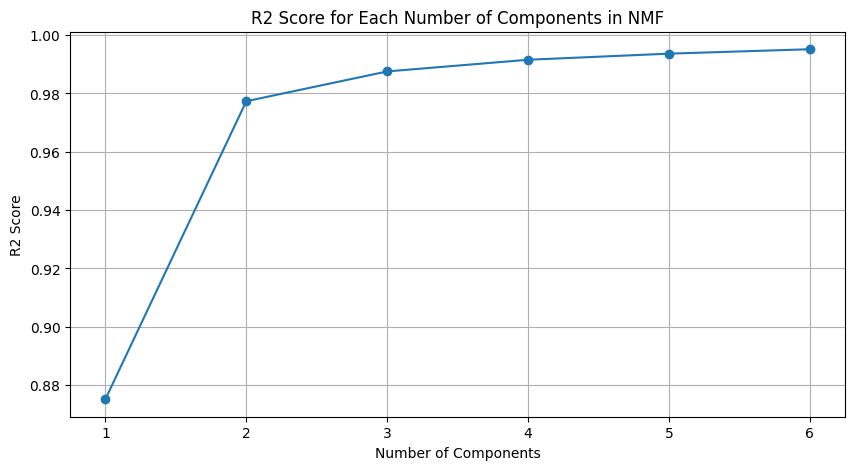

R2 score with 4 components: 0.99


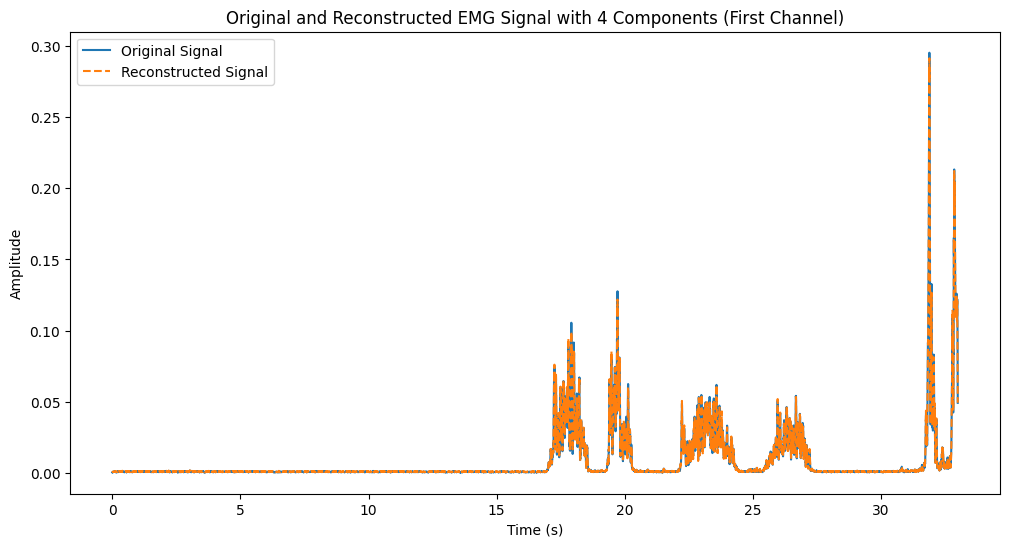

In [16]:
# Calculate R2 score for different numbers of components in NMF
r2_scores = []
component_range = range(1, 7) 

for n_components in component_range:
    model = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
    W = model.fit_transform(combined_smoothed_signals)
    H = model.components_
    <<
    # Reconstruct the signal
    reconstructed_signal = np.dot(W, Haa)
    
    # Calculate R2 score
    total_variance = np.sum((combined_smoothed_signals - combined_smoothed_signals.mean(axis=0))**2)
    residual_variance = np.sum((combined_smoothed_signals - reconstructed_signal)**2)
    r2_score = 1 - residual_variance / total_variance
    r2_scores.append(r2_score)

# Plot R2 scores
plt.figure(figsize=(10, 5))
plt.plot(component_range, r2_scores, marker='o')
plt.title('R2 Score for Each Number of Components in NMF')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

# Output R2 score for a chosen number of components
print(f"R2 score with {n_synergies} components: {r2_scores[n_synergies-1]:.2f}")

# Plot the original and reconstructed signals for the first channel
channel_to_plot = 0
plt.figure(figsize=(12, 6))
plt.plot(time, combined_smoothed_signals[:, channel_to_plot], label='Original Signal')
plt.plot(time, reconstructed_signal[:, channel_to_plot], linestyle='--', label='Reconstructed Signal')
plt.title(f'Original and Reconstructed EMG Signal with {n_synergies} Components (First Channel)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

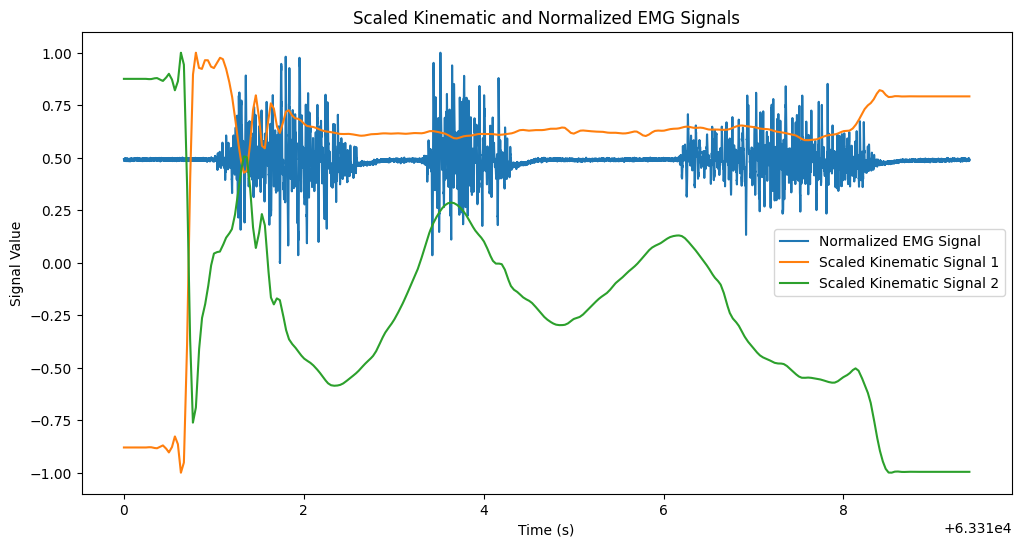

In [69]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Extract start time from filenames
def extract_start_time(filename, is_emg=False):
    if is_emg:
        time_str = filename.split('_')[0][-6:]  # Extract "173454"
    else:
        time_str = filename.split('_')[1:4]  # Extract "17", "35", "02"
        time_str = ''.join(time_str)  # Combine to "173502"

    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# File names
kinematic_filename = "recording_17_35_10_gmt+2"
emg_filename = "20240801173454_EMGLudgerGrit128.csv"

# Extract start times
kinematic_start_time = extract_start_time(kinematic_filename)
emg_start_time = extract_start_time(emg_filename, is_emg=True)

# Load kinematic data
kinematic_data_path = r'C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\FreeMoCap\recording_sessions\session_2024-08-01_17_30_50\recording_17_35_10_gmt+2\output_data\mediapipe_right_hand_3d_xyz.csv'
kinematic_data = pd.read_csv(kinematic_data_path)

# Kinematic data parameters
kinematic_sample_rate = 30  # 30 Hz
kinematic_duration = len(kinematic_data) / kinematic_sample_rate
kinematic_time_vector = np.arange(kinematic_start_time, kinematic_start_time + kinematic_duration, 1 / kinematic_sample_rate)

# Load EMG data
emg_data_path = r'C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Setup\OTB+\20240801173454_EMGLudgerGrit128.csv'
emg_data = pd.read_csv(emg_data_path, skiprows=3, sep=';', header=None)
emg_sample_rate = 1 / 0.0005  # 2000 Hz
emg_duration = len(emg_data) / emg_sample_rate
emg_time_vector = np.arange(emg_start_time, emg_start_time + emg_duration, 1 / emg_sample_rate)

# Find overlapping time interval
start_time = max(emg_time_vector[0], kinematic_time_vector[0])
end_time = min(emg_time_vector[-1], kinematic_time_vector[-1])

# Create time vectors for the overlapping range
trimmed_kinematic_time = np.arange(start_time, end_time, 1 / kinematic_sample_rate)
trimmed_emg_time = np.arange(start_time, end_time, 1 / emg_sample_rate)

# Find indices for the overlapping range
kinematic_start_index = np.searchsorted(kinematic_time_vector, start_time)
kinematic_end_index = np.searchsorted(kinematic_time_vector, end_time)
emg_start_index = np.searchsorted(emg_time_vector, start_time)
emg_end_index = np.searchsorted(emg_time_vector, end_time)

# Slice the signals based on the indices
trimmed_kinematic_signals = kinematic_data.iloc[kinematic_start_index:kinematic_end_index, 1:].to_numpy()
trimmed_emg_signals = emg_data.iloc[emg_start_index:emg_end_index, 1:].to_numpy()

# Interpolate the kinematic data to match EMG time vector
interpolated_kinematic_signals = np.zeros((len(trimmed_emg_time), trimmed_kinematic_signals.shape[1]))

for i in range(trimmed_kinematic_signals.shape[1]):
    interpolation_function = interp1d(trimmed_kinematic_time, trimmed_kinematic_signals[:, i], kind='linear', fill_value="extrapolate")
    interpolated_kinematic_signals[:, i] = interpolation_function(trimmed_emg_time)

# Normalize EMG data using min-max normalization
def min_max_normalize(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min) / (data_max - data_min + 1e-9)

normalized_emg_signals = min_max_normalize(trimmed_emg_signals)

# Normalize kinematic data to [-1, 1]
def min_max_scale_to_neg1_pos1(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return 2 * (data - data_min) / (data_max - data_min + 1e-9) - 1

scaled_kinematic_signals = min_max_scale_to_neg1_pos1(interpolated_kinematic_signals)

# Combine EMG and Kinematic data for MMF analysis
combined_data = np.hstack((normalized_emg_signals, scaled_kinematic_signals))

# Plot the normalized results
plt.figure(figsize=(12, 6))
plt.plot(trimmed_emg_time, normalized_emg_signals[:, 0], label='Normalized EMG Signal')
plt.plot(trimmed_emg_time, scaled_kinematic_signals[:, 0], label='Scaled Kinematic Signal 1')
plt.plot(trimmed_emg_time, scaled_kinematic_signals[:, 1], label='Scaled Kinematic Signal 2')
plt.title('Scaled Kinematic and Normalized EMG Signals')
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.legend()
plt.show()


Iteration 0, Cost: 467122.8901915289
W matrix (first few values): [0.00693882 0.00816534 0.01000773 0.00110595 0.01236892]
C matrix (first few values): [0.00596259 0.00242898 0.00592036 0.00650155 0.00288538]


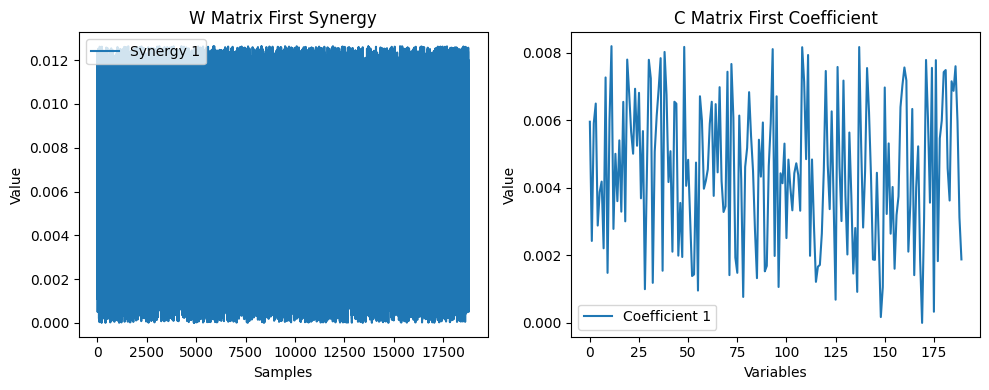

Iteration 100, Cost: 463629.25733172597
W matrix (first few values): [0.00636285 0.00725618 0.00856953 0.00215936 0.01027567]
C matrix (first few values): [0.08316056 0.0757621  0.08050915 0.07527639 0.07034389]


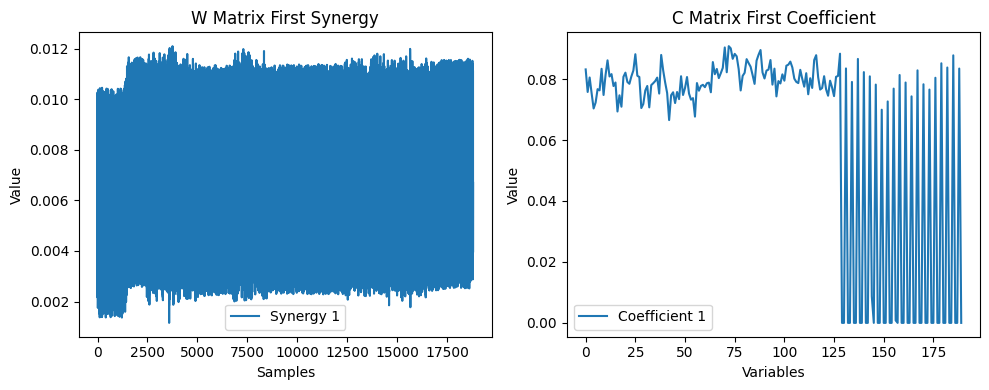

Iteration 200, Cost: 382436.43302565825
W matrix (first few values): [0.00442428 0.00450559 0.00454755 0.00416162 0.00466677]
C matrix (first few values): [1.99615192 1.85198025 1.93084467 1.79497368 1.71273758]


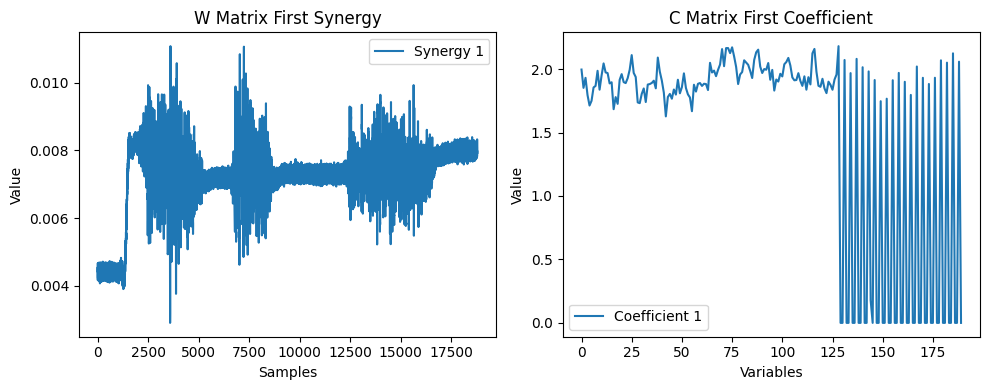

Iteration 300, Cost: 135071.6530185386
W matrix (first few values): [0.00410333 0.00411927 0.00412216 0.00409626 0.00413971]
C matrix (first few values): [17.42365201 16.16512328 16.85209224 15.6676807  14.95045538]


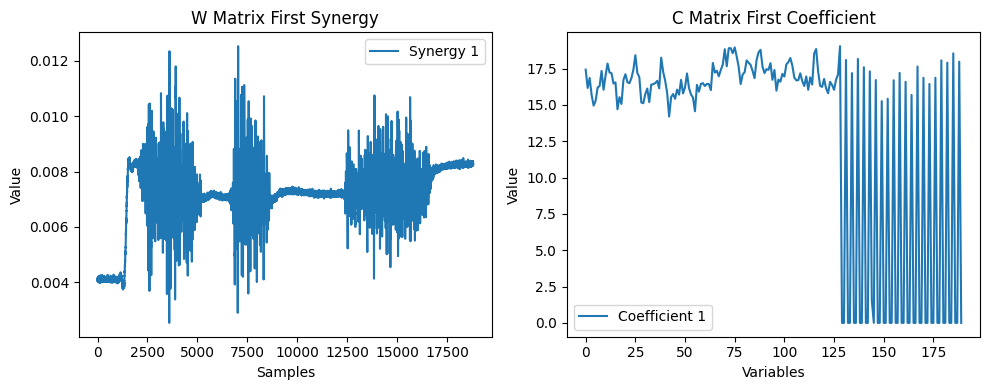

Iteration 400, Cost: 135019.4620843348
W matrix (first few values): [0.00339501 0.00341658 0.00343705 0.00341915 0.00343512]
C matrix (first few values): [17.44998794 16.18875835 16.87616721 15.69182696 14.97328676]


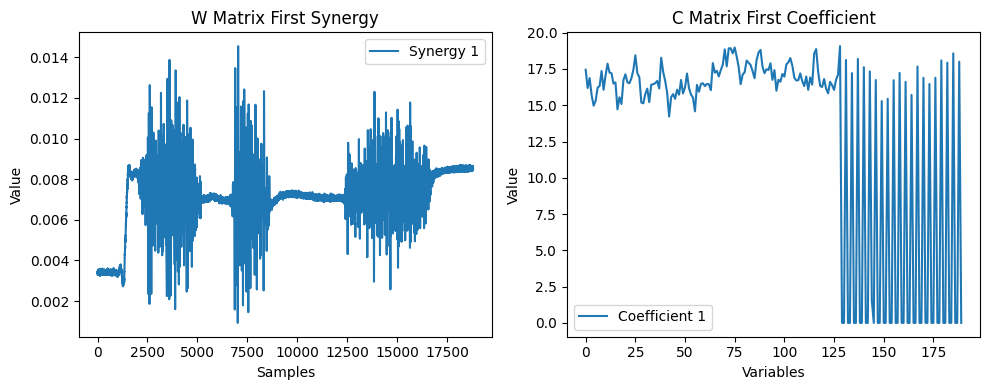

Iteration 500, Cost: 134972.40238076588
W matrix (first few values): [0.0017062  0.00170233 0.00175275 0.00176697 0.00172623]
C matrix (first few values): [17.50164659 16.23595958 16.92481388 15.7389155  15.01802771]


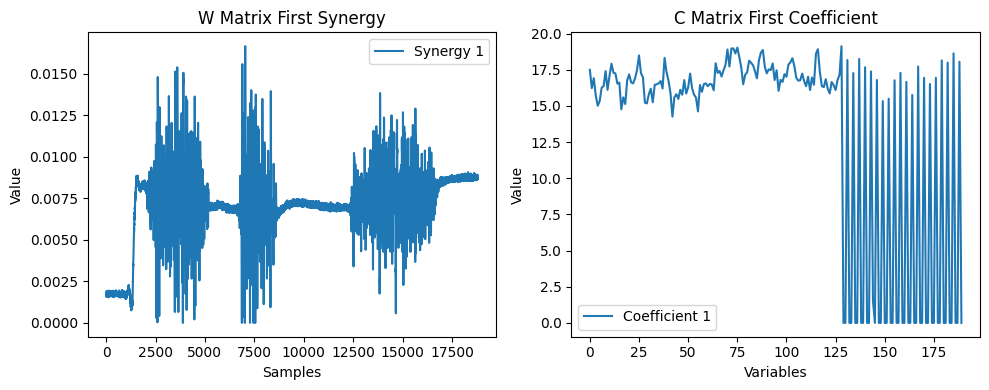

Iteration 600, Cost: 134918.43723453922
W matrix (first few values): [0. 0. 0. 0. 0.]
C matrix (first few values): [17.69401177 16.41377189 17.10962581 15.91270235 15.18368278]


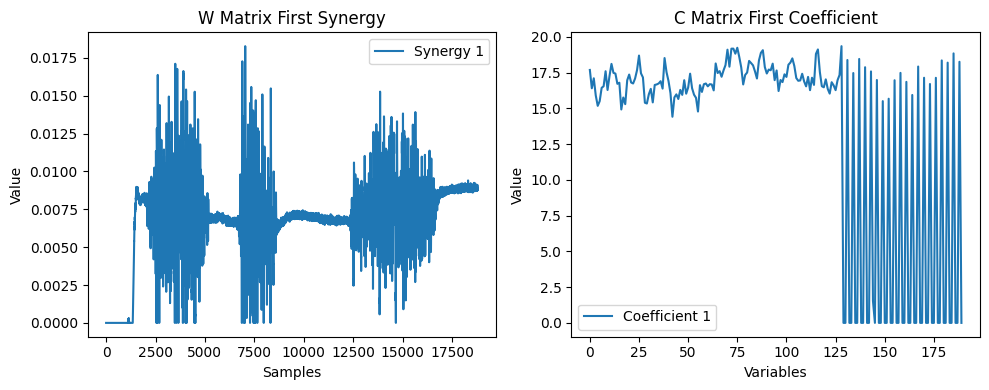

Iteration 700, Cost: 134862.0680633283
W matrix (first few values): [0. 0. 0. 0. 0.]
C matrix (first few values): [17.98574903 16.68385233 17.39060824 16.17599145 15.43477171]


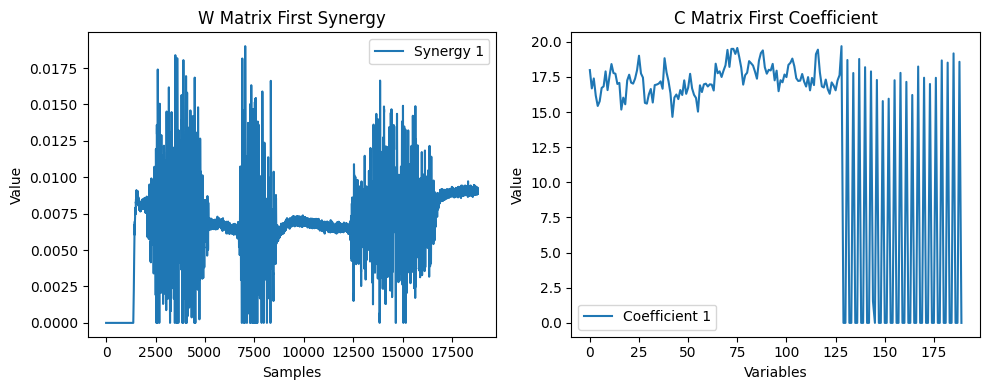

Iteration 800, Cost: 134792.4468015579
W matrix (first few values): [0. 0. 0. 0. 0.]
C matrix (first few values): [18.31958253 16.99306518 17.71235846 16.47725416 15.72212849]


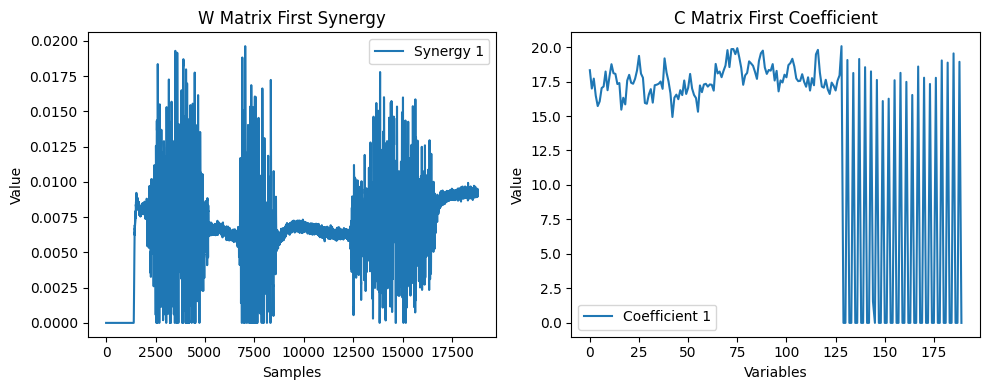

Iteration 900, Cost: 134728.74063872738
W matrix (first few values): [0. 0. 0. 0. 0.]
C matrix (first few values): [18.44527616 17.10928139 17.83292074 16.59140786 15.83097532]


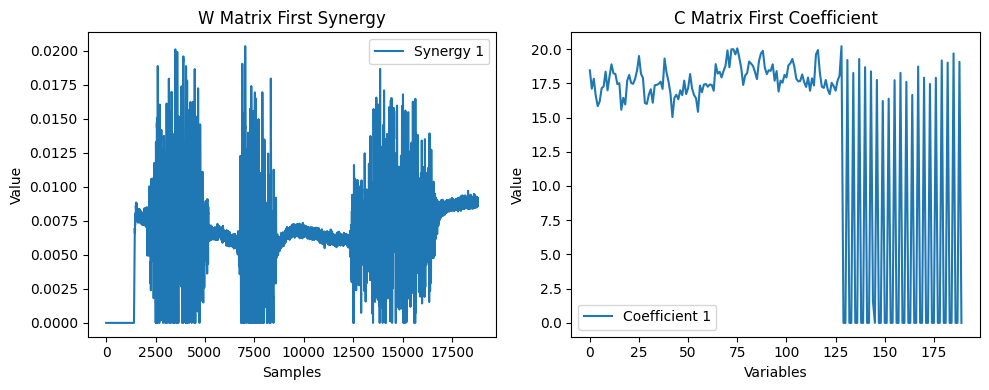

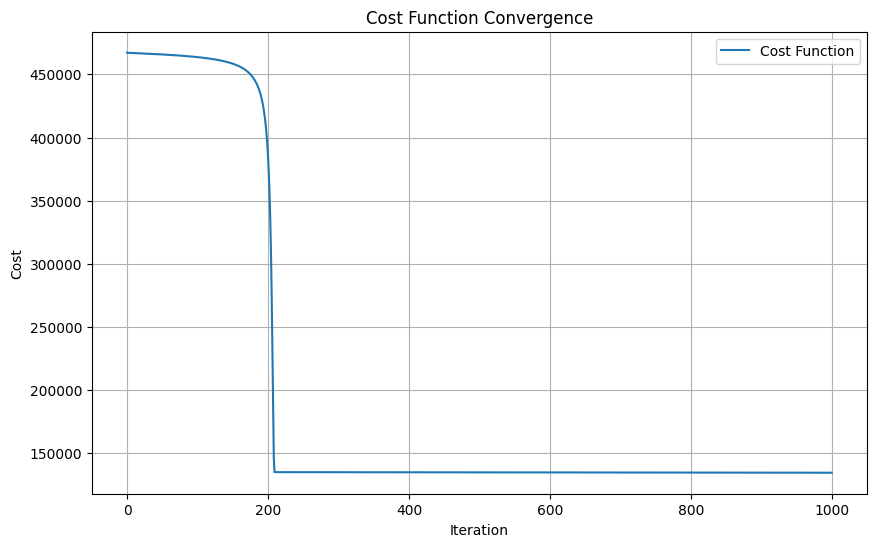

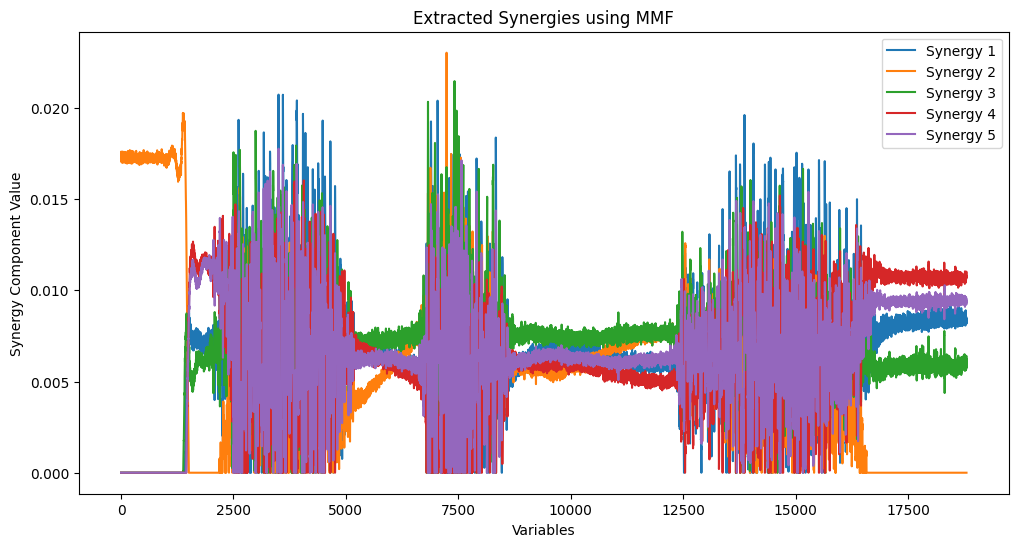

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Define the MMF algorithm
def initialize_matrices(data, n_synergies):
    np.random.seed(0)  # For reproducibility
    W = np.random.rand(data.shape[0], n_synergies) * 0.01  # Initialize with small values
    C = np.random.rand(n_synergies, data.shape[1]) * 0.01
    return W, C

def update_mmf(X, W, C, mu_W, mu_C, lambd, k):
    # Calculate the gradient updates
    W_update = mu_W * ((X @ C.T) - (W @ (C @ C.T)) - lambd * W)
    C_update = mu_C * ((W.T @ X) - (W.T @ W @ C))

    # Gradient clipping to prevent overflow
    W_update = np.clip(W_update, -0.01, 0.01)
    C_update = np.clip(C_update, -0.01, 0.01)

    # Update matrices
    W += W_update
    C += C_update

    # Enforce non-negativity for EMG components
    W[:, :k] = np.maximum(W[:, :k], 0)
    C[:k, :] = np.maximum(C[:k, :], 0)

    # Normalize W and adjust C
    W_norms = np.linalg.norm(W, axis=0)
    # Avoid division by zero
    W_norms[W_norms == 0] = 1
    W /= W_norms
    C *= W_norms[:, np.newaxis]
    
    return W, C

def mixed_matrix_factorization(X, n_synergies, max_iter=1000, mu_W=1e-5, mu_C=1e-5, lambd=0.1):
    W, C = initialize_matrices(X, n_synergies)
    k = normalized_emg_signals.shape[1]  # Number of EMG channels
    cost_history = []

    for iteration in range(max_iter):
        W, C = update_mmf(X, W, C, mu_W, mu_C, lambd, k)
        
        # Calculate the cost function value
        cost = 0.5 * np.linalg.norm(X - W @ C) ** 2 + 0.5 * lambd * np.linalg.norm(W, 'fro') ** 2
        cost_history.append(cost)
        
        # Print cost and matrix summaries every 100 iterations
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Cost: {cost}")
            print(f"W matrix (first few values): {W[:5, 0]}")
            print(f"C matrix (first few values): {C[0, :5]}")
            
            # Optional: plot first few synergies and coefficients
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(W[:, 0], label='Synergy 1')
            plt.title('W Matrix First Synergy')
            plt.xlabel('Samples')
            plt.ylabel('Value')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(C[0, :], label='Coefficient 1')
            plt.title('C Matrix First Coefficient')
            plt.xlabel('Variables')
            plt.ylabel('Value')
            plt.legend()
            plt.tight_layout()
            plt.show()

    # Plot cost function history
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history, label='Cost Function')
    plt.title('Cost Function Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()

    return W, C

# Define number of synergies
n_synergies = 5  # Adjust based on your specific analysis

# Apply MMF algorithm
W, C = mixed_matrix_factorization(combined_data, n_synergies)

# Plot final synergies
plt.figure(figsize=(12, 6))
for i in range(n_synergies):
    plt.plot(W[:, i], label=f'Synergy {i+1}')
plt.title('Extracted Synergies using MMF')
plt.xlabel('Variables')
plt.ylabel('Synergy Component Value')
plt.legend()
plt.show()


Evaluation of MMF Performance and Reconstruction of the original signal

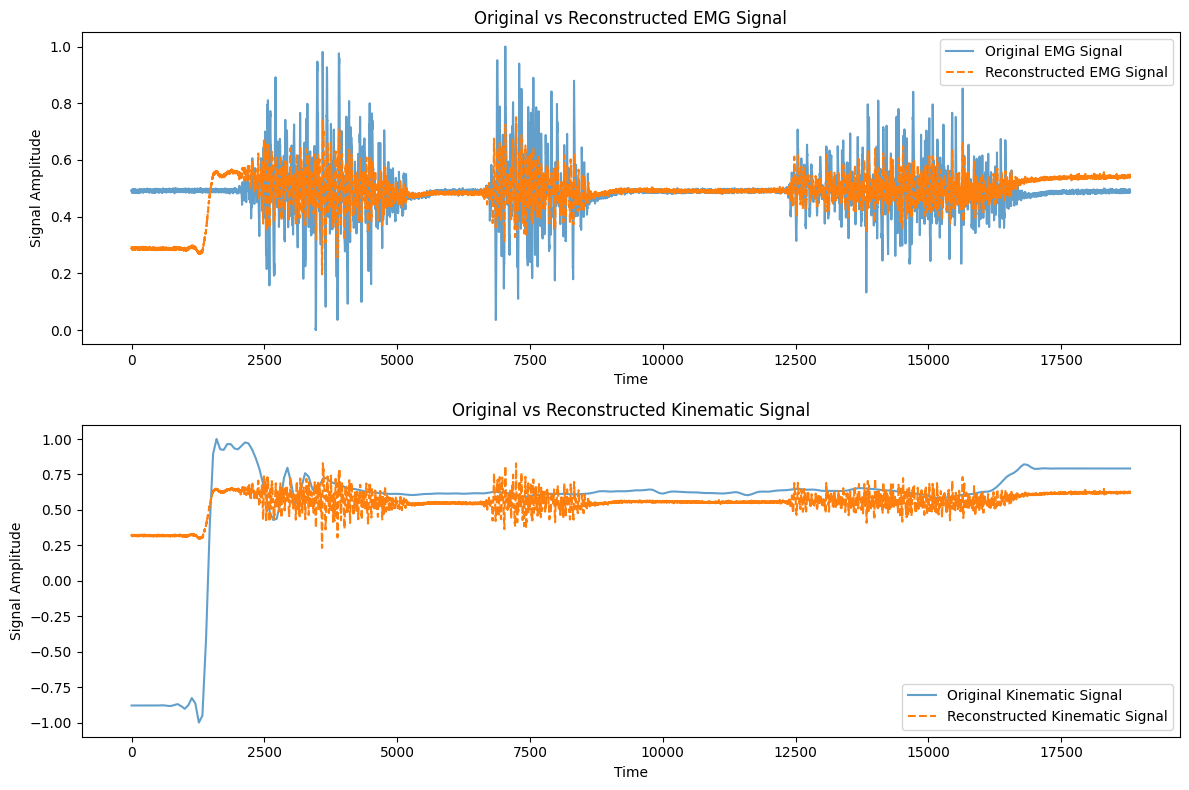

EMG Reconstruction R^2: -0.0306
Kinematic Reconstruction R^2: 0.3015


In [78]:
# Reconstruct the data using the W and C matrices
reconstructed_data = W @ C

# Plot original vs. reconstructed signals
plt.figure(figsize=(12, 8))

# Plot original and reconstructed EMG signals
plt.subplot(2, 1, 1)
plt.plot(combined_data[:, 0], label='Original EMG Signal', alpha=0.7)
plt.plot(reconstructed_data[:, 0], label='Reconstructed EMG Signal', linestyle='--')
plt.title('Original vs Reconstructed EMG Signal')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.legend()

# Plot original and reconstructed Kinematic signals
plt.subplot(2, 1, 2)
plt.plot(combined_data[:, normalized_emg_signals.shape[1]], label='Original Kinematic Signal', alpha=0.7)
plt.plot(reconstructed_data[:, normalized_emg_signals.shape[1]], label='Reconstructed Kinematic Signal', linestyle='--')
plt.title('Original vs Reconstructed Kinematic Signal')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate R^2 score
def r2_score(original, reconstructed):
    ss_res = np.sum((original - reconstructed) ** 2)
    ss_tot = np.sum((original - np.mean(original)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate R^2 for EMG signals
r2_emg = r2_score(
    combined_data[:, :normalized_emg_signals.shape[1]], 
    reconstructed_data[:, :normalized_emg_signals.shape[1]]
)

# Calculate R^2 for kinematic signals
r2_kinematic = r2_score(
    combined_data[:, normalized_emg_signals.shape[1]:], 
    reconstructed_data[:, normalized_emg_signals.shape[1]:]
)

print(f"EMG Reconstruction R^2: {r2_emg:.4f}")
print(f"Kinematic Reconstruction R^2: {r2_kinematic:.4f}")